In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import re
from liftover import get_lifter
import seaborn as sns
import networkx as nx
import pickle
sys.path.append("/n/holystore01/LABS/liau_lab/Users/heejinroh/TDAC_seq/tdac_seq")
from ddda_dataset import *
%matplotlib inline
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec

In [2]:
# Create a folder to save plots
working_dir = "/n/holystore01/LABS/liau_lab/Users/heejinroh/Yan_minimap/analysis/HJR235"
plot_dir = os.path.join("/n/holystore01/LABS/liau_lab/Users/heejinroh/Yan_minimap/analysis/HJR235/", "plot")
os.system("mkdir -p " + plot_dir)

# Create a dictionary for reference regions
ref_range_dict = {
    'HJR235': ('chr7', 27158522, 27163197)
}

# Initialize ddda_dataset
ddda_data = ddda_dataset(
    ID = "HJR_235", 
    region_dict = ref_range_dict, 
    genome_file = "/n/holystore01/LABS/liau_lab/Users/heejinroh/Genome/GCA_000001405.15_GRCh38_no_alt_analysis_set.fna", 
    fastq_file = "/n/holystore01/LABS/liau_lab/Users/heejinroh/HJR235_050624/HJR235_4/HJR235_4.fastq.gz", 
    working_dir = "/n/holystore01/LABS/liau_lab/Users/heejinroh/Yan_minimap/analysis/HJR235/"
)

# Load DddA bias model
with open("/n/holystore01/LABS/liau_lab/Users/heejinroh/Yan_minimap/code/bias_dict.pkl", "rb") as f:
    ddda_data.bias_model = pickle.load(f)



Loading reference genome
Extracting sequences for each locus


In [3]:
# Align reads
gap_threshold = 500
ddda_data.align_reads(
    start_gap_threshold = gap_threshold,
    end_gap_threshold = gap_threshold
)


Computing sequence bias


100%|██████████| 162206/162206 [03:25<00:00, 788.08it/s]


122522 reads aligned. 39684 reads unaligned


In [32]:
with open("/n/holystore01/LABS/liau_lab/Users/heejinroh/Yan_minimap/analysis/HJR235/HJR235_4_ddda.pkl", "wb") as f:
    pickle.dump(ddda_data, f)

In [33]:
with open('/n/holystore01/LABS/liau_lab/Users/heejinroh/Yan_minimap/analysis/HJR235/HJR235_4_ddda.pkl', 'rb') as f:
    ddda_data = pickle.load(f)

In [4]:
# Position of the cutsite(CTCF motif)
motif_start, motif_end = 2623, 2645 

In [5]:
locus = "HJR235"

# Find reads where the sgRNA target site is covered by a deletion
del_start, del_end = motif_start, motif_end
del_matrix = ddda_data.del_dict[locus]
motif_del = np.array(np.max(del_matrix[:, del_start:del_end], axis=1).todense())[:, 0]
del_read_inds = np.where(motif_del == 1)[0]

# Only keep reads where positions outside of the vicinity of the sgRNA target site are not deleted
upstream_del = np.array(np.max(del_matrix[:, :del_start], axis=1).todense())[:, 0]
downstream_del = np.array(np.max(del_matrix[:, del_end:], axis=1).todense())[:, 0]
upstream_filter = upstream_del == 0
downstream_filter = downstream_del == 0
filter = np.where(upstream_filter & downstream_filter)[0]
del_read_inds = np.intersect1d(del_read_inds, filter)

# Separately, also find reads without any deletion as a control
undel_read_inds = np.where(np.array(np.max(del_matrix, axis=1).todense())[:, 0] == 0)[0]

In [6]:
print(len(undel_read_inds))
print(len(del_read_inds))

81751
2618


In [7]:
# Down-sample the number of reads
min_num = min(len(del_read_inds), len(undel_read_inds),10000)
del_read_inds = np.random.choice(del_read_inds, min_num, replace=False)
undel_read_inds = np.random.choice(undel_read_inds, min_num, replace=False)

In [8]:
print(len(undel_read_inds))
print(len(del_read_inds))

2618
2618


In [9]:
# De-duplicate reads
del_read_ids = ddda_data.dedup_reads(
    locus = locus, 
    read_ids = np.array(ddda_data.read_ids[locus])[del_read_inds]
)
undel_read_ids = ddda_data.dedup_reads(
    locus = locus, 
    read_ids = np.array(ddda_data.read_ids[locus])[undel_read_inds]
    
)
del_read_inds = np.array([ddda_data.read_ids[locus].index(i) for i in del_read_ids])
undel_read_inds = np.array([ddda_data.read_ids[locus].index(i) for i in undel_read_ids])

100%|██████████| 2618/2618 [00:00<00:00, 6427.11it/s]
2618it [00:00, 1278013.02it/s]
100%|██████████| 2618/2618 [00:00<00:00, 6406.21it/s]
2618it [00:00, 1252788.12it/s]


In [10]:
print(len(undel_read_inds))
print(len(del_read_inds))

1197
811


In [11]:
# Combine deleted and undeleted reads 
selected_read_inds = np.concatenate([del_read_inds, undel_read_inds])
selected_reads = np.array(ddda_data.read_ids[locus])[selected_read_inds]
selected_del_flags = np.concatenate([np.ones(len(del_read_inds)), np.zeros(len(undel_read_inds))])
selection_dict = {"HJR235":selected_reads}

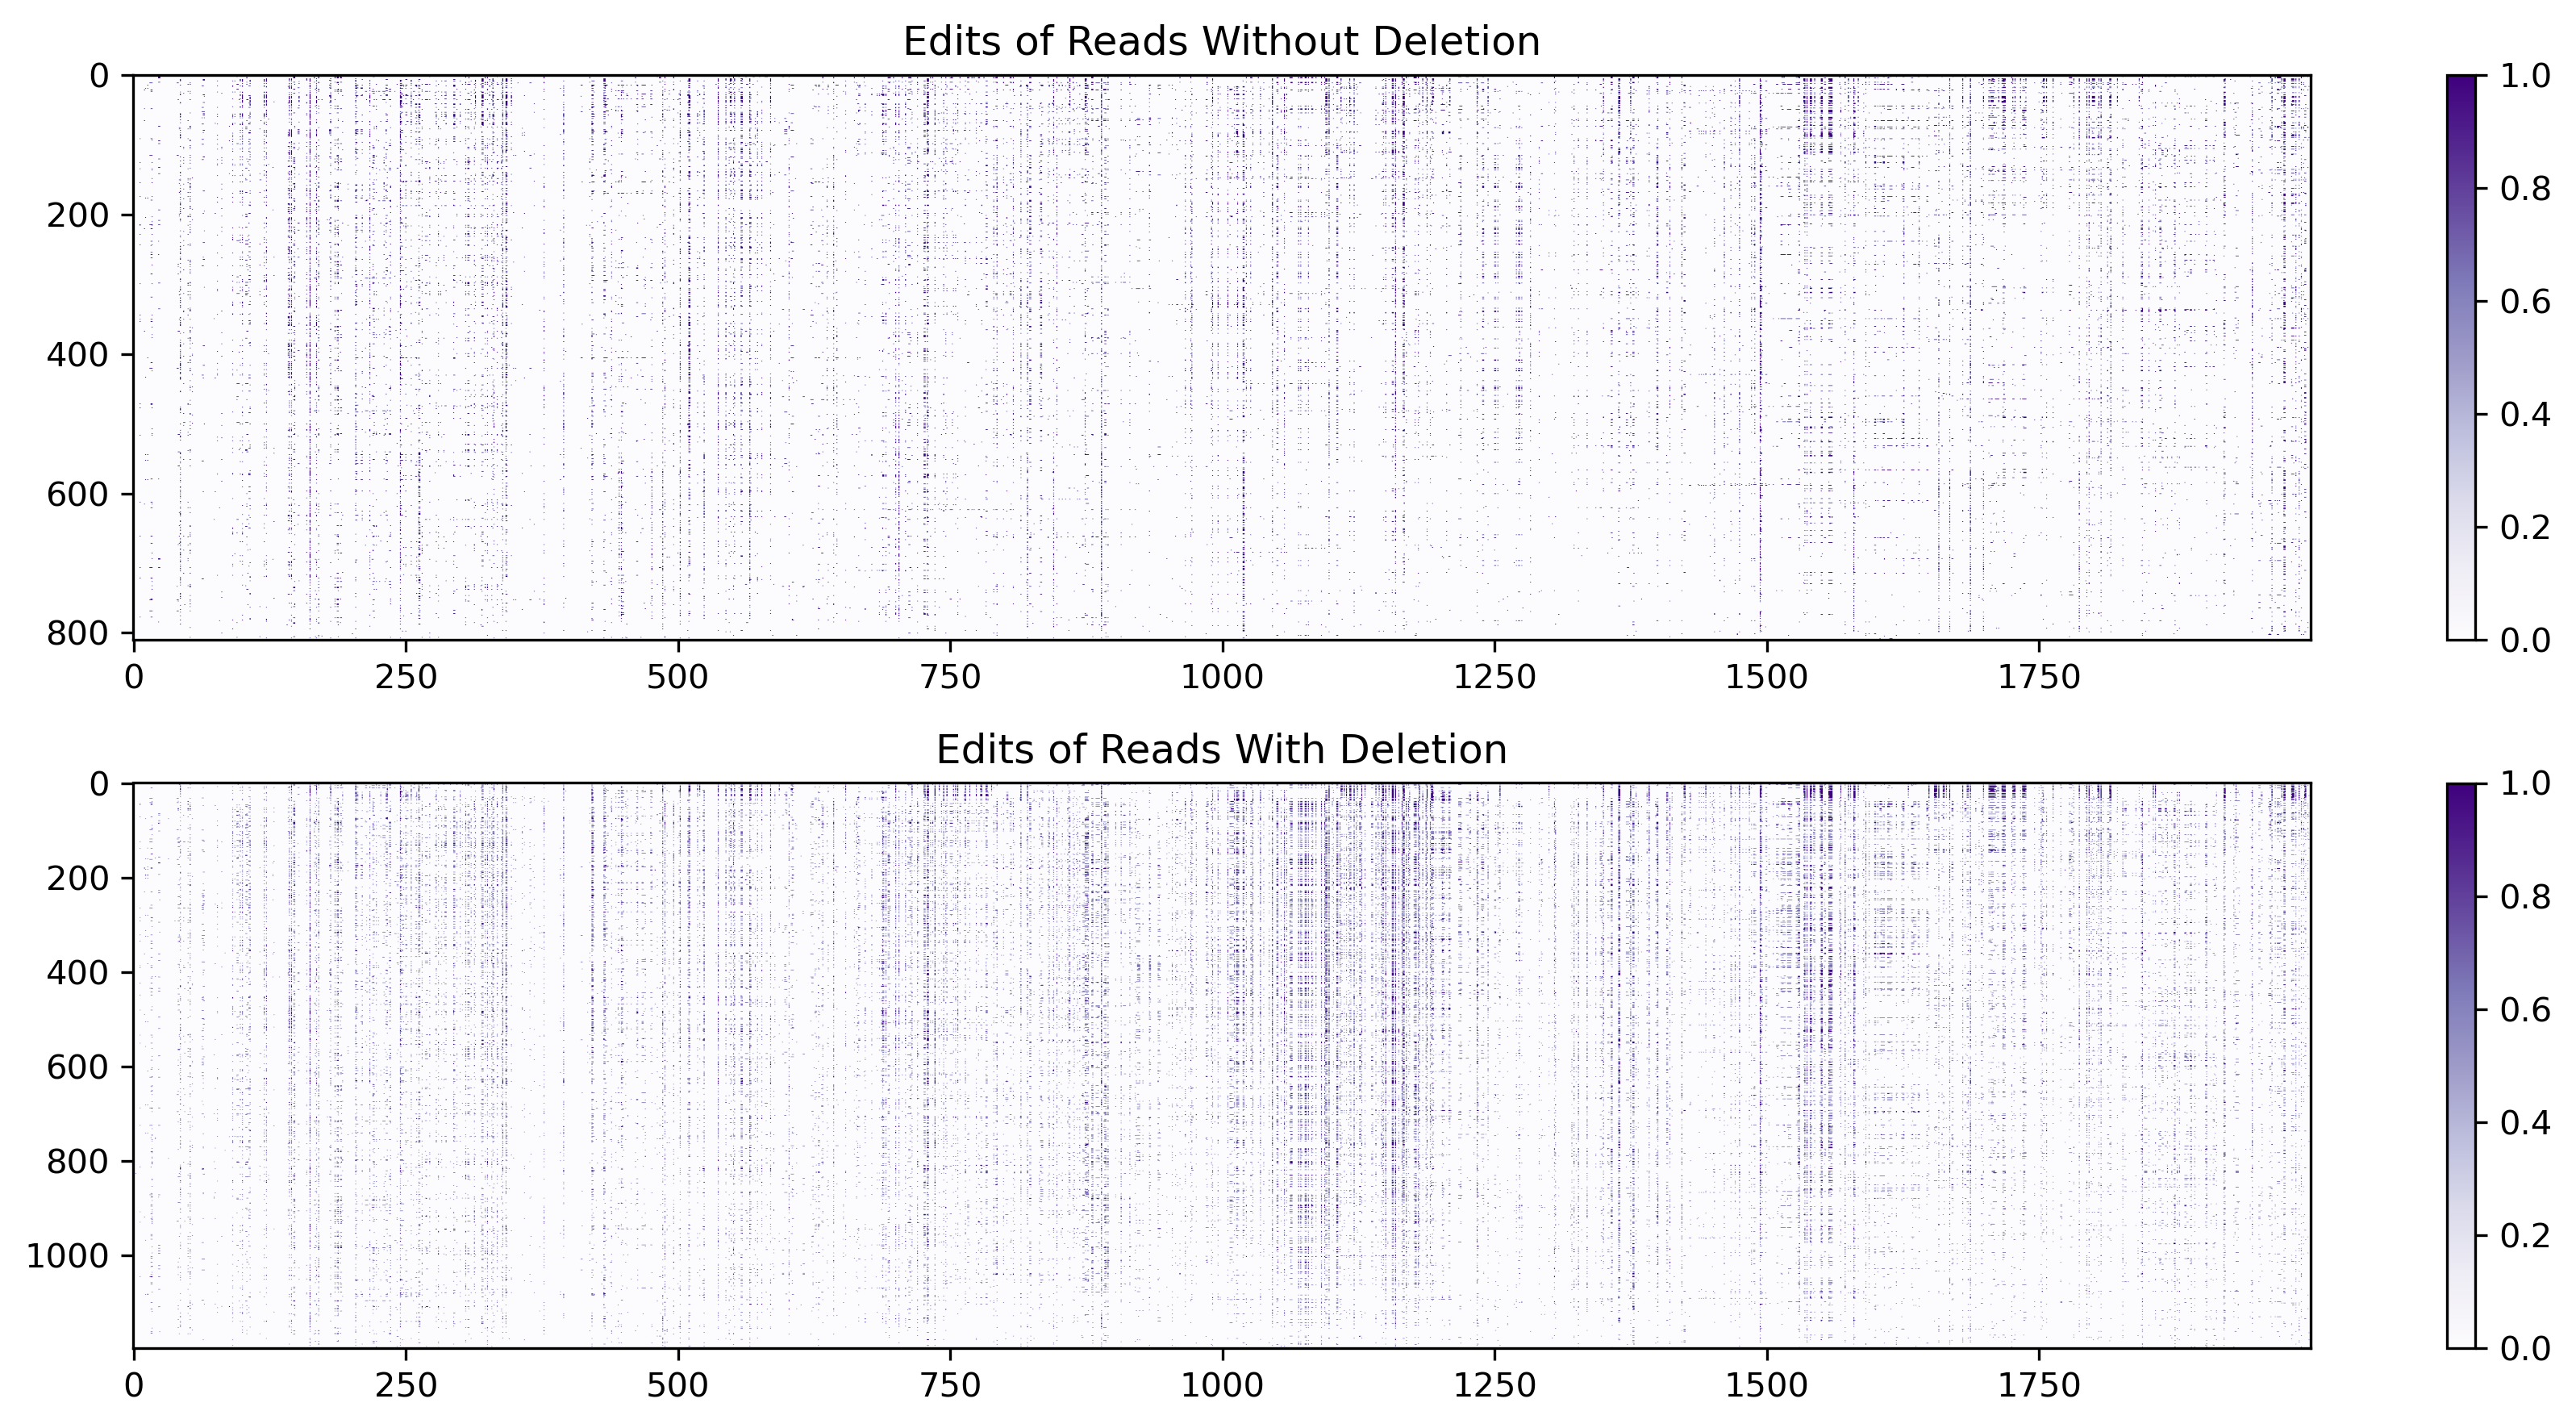

In [12]:
edits = np.array(ddda_data.edit_dict[locus][selected_read_inds, :].todense())
read_edit_num = np.sum(edits, axis=1)
plot_range = np.arange(1500, 3500)
fig, axes = plt.subplots(2, 1, dpi=300, figsize=(12, 6))

# Plot edits of reads without deletion
del_filter = np.where(selected_del_flags == 1)[0]
row_order = [i for i in np.argsort(-read_edit_num) if i in del_filter]

# Use imshow for the heatmap-style plot
im = axes[0].imshow(edits[row_order, :][:, plot_range], aspect='auto', cmap="Purples", vmin=0, vmax=1)
axes[0].set_title("Edits of Reads Without Deletion")
fig.colorbar(im, ax=axes[0])  # Add a colorbar

# Plot edits of reads with deletion
undel_filter = np.where(selected_del_flags == 0)[0]
row_order = [i for i in np.argsort(-read_edit_num) if i in undel_filter]

# Use imshow for the heatmap-style plot
im = axes[1].imshow(edits[row_order, :][:, plot_range], aspect='auto', cmap="Purples", vmin=0, vmax=1)
axes[1].set_title("Edits of Reads With Deletion")
fig.colorbar(im, ax=axes[1])  # Add a colorbar

# Save the figure
plt.tight_layout()
#plt.savefig(os.path.join(plot_dir, "single_read_edits.pdf"))


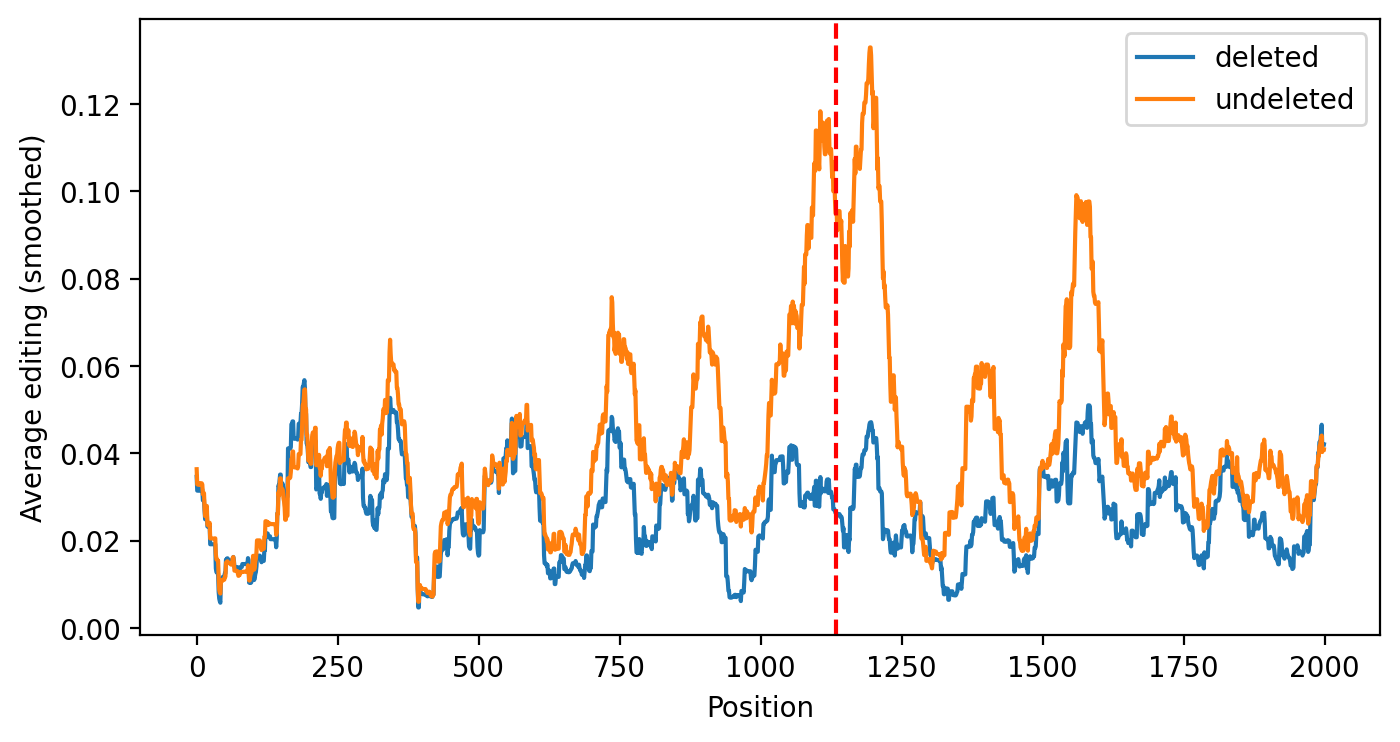

In [13]:
# Calculate average editing rate for each condition
track_deleted = np.mean(edits[np.array(selected_del_flags) == 1, :], axis = 0)
track_undeleted = np.mean(edits[np.array(selected_del_flags) == 0, :], axis = 0)

# Smooth tracks
track_deleted = np.convolve(track_deleted, np.ones(50))/50
track_undeleted = np.convolve(track_undeleted, np.ones(50))/50
track_deleted = track_deleted[plot_range]
track_undeleted = track_undeleted[plot_range]

# Visualize results
plt.figure(dpi=200, figsize=(8, 4))
plt.plot(np.arange(len(track_deleted)), track_deleted, label="deleted")
plt.plot(np.arange(len(track_undeleted)), track_undeleted, label="undeleted")
plt.axvline(
    x = (motif_start + motif_end) / 2 - min(plot_range),
    ymin=0, ymax=1, linestyle="dashed", color="Red")
plt.xlabel("Position")
plt.ylabel("Average editing (smoothed)")
plt.legend()
#plt.savefig(os.path.join(plot_dir, "single_read_edits_agg.pdf"))
plt.show()

In [14]:
#sgRNA barplot
CTCF_x_values = np.arange(ref_range_dict[locus][1], ref_range_dict[locus][2]+1)
CTCF_values = np.zeros_like(CTCF_x_values)
CTCF_values[(CTCF_x_values >= 27161134) & (CTCF_x_values < 27161153)] = 3  # Adjust indices as needed
CTCF_values_region=CTCF_values[plot_range]
CTCF_x_values_region=CTCF_x_values[plot_range]

In [15]:
#sgRNA barplot
YY1_x_values = np.arange(ref_range_dict[locus][1], ref_range_dict[locus][2]+1)
YY1_values = np.zeros_like(CTCF_x_values)
YY1_values[(YY1_x_values >= 27161148) & (YY1_x_values < 27161161)] = 3  # Adjust indices as needed
YY1_values_region=YY1_values[plot_range]
YY1_x_values_region=YY1_x_values[plot_range]

In [16]:
# Calculate nucleosome footprints for individual reads
footprints_dict = ddda_data.get_footprints(
    selection_dict, 
    footprint_radii = [50], 
    combine_sides="max_pval")

# Convert to -log10 pval
fp_nuc = np.squeeze(np.array([i for i in footprints_dict[locus].values()]))
fp_nuc = -np.log10(fp_nuc)

Computing footprints for HJR235


100%|██████████| 2008/2008 [00:08<00:00, 250.46it/s]


In [17]:
# Calculate nucleosome footprints for individual reads
footprints_dict = ddda_data.get_footprints(
    selection_dict, 
    footprint_radii = [25], 
    combine_sides="max_pval")

# Convert to -log10 pval
fp_tf = np.squeeze(np.array([i for i in footprints_dict[locus].values()]))
fp_tf = -np.log10(fp_tf)

Computing footprints for HJR235


100%|██████████| 2008/2008 [00:06<00:00, 305.10it/s]


In [18]:
ATAC = '/n/holyscratch01/liau_lab/heejin/SRA/SRR7010323_rmdups.bedgraph'
bedgraph_data = pd.read_csv(ATAC, sep='\t', header=None, names=['chrom', 'start', 'end', 'value'])

# chr21이고 start가 38118238에서 38127665 사이인 데이터 필터링
filtered_data = bedgraph_data[(bedgraph_data['chrom'] == ref_range_dict[locus][0]) &
                              (bedgraph_data['start'] >= ref_range_dict[locus][1]) &
                              (bedgraph_data['start'] <= ref_range_dict[locus][2])]

# x값과 y값 설정
all_positions = pd.DataFrame({'start': np.arange(ref_range_dict[locus][1], ref_range_dict[locus][2]+1)})

# Merging with the filtered data, filling missing values with zero
merged_data = pd.merge(all_positions, filtered_data, on='start', how='left').fillna(0)

ATAC_x_values = merged_data['start']
ATAC_y_values = merged_data['value'].values



In [19]:
ATAC_x_values_plot = ATAC_x_values[1500:3500]
ATAC_y_values_plot = ATAC_y_values[1500:3500]
ATAC_y_values_convolve_plot=np.convolve(ATAC_y_values_plot, np.ones(50), 'same')/50

In [20]:
#open region
open_x_values = np.arange(ref_range_dict[locus][1], ref_range_dict[locus][2]+1)
open_values = np.zeros_like(open_x_values)
open_values[(open_x_values >= (27158522+2500)) & (open_x_values < (27158522+1250+1500))] = 3  # Adjust indices as needed
open_values_region=open_values[plot_range]
open_x_values_region=open_x_values[plot_range]

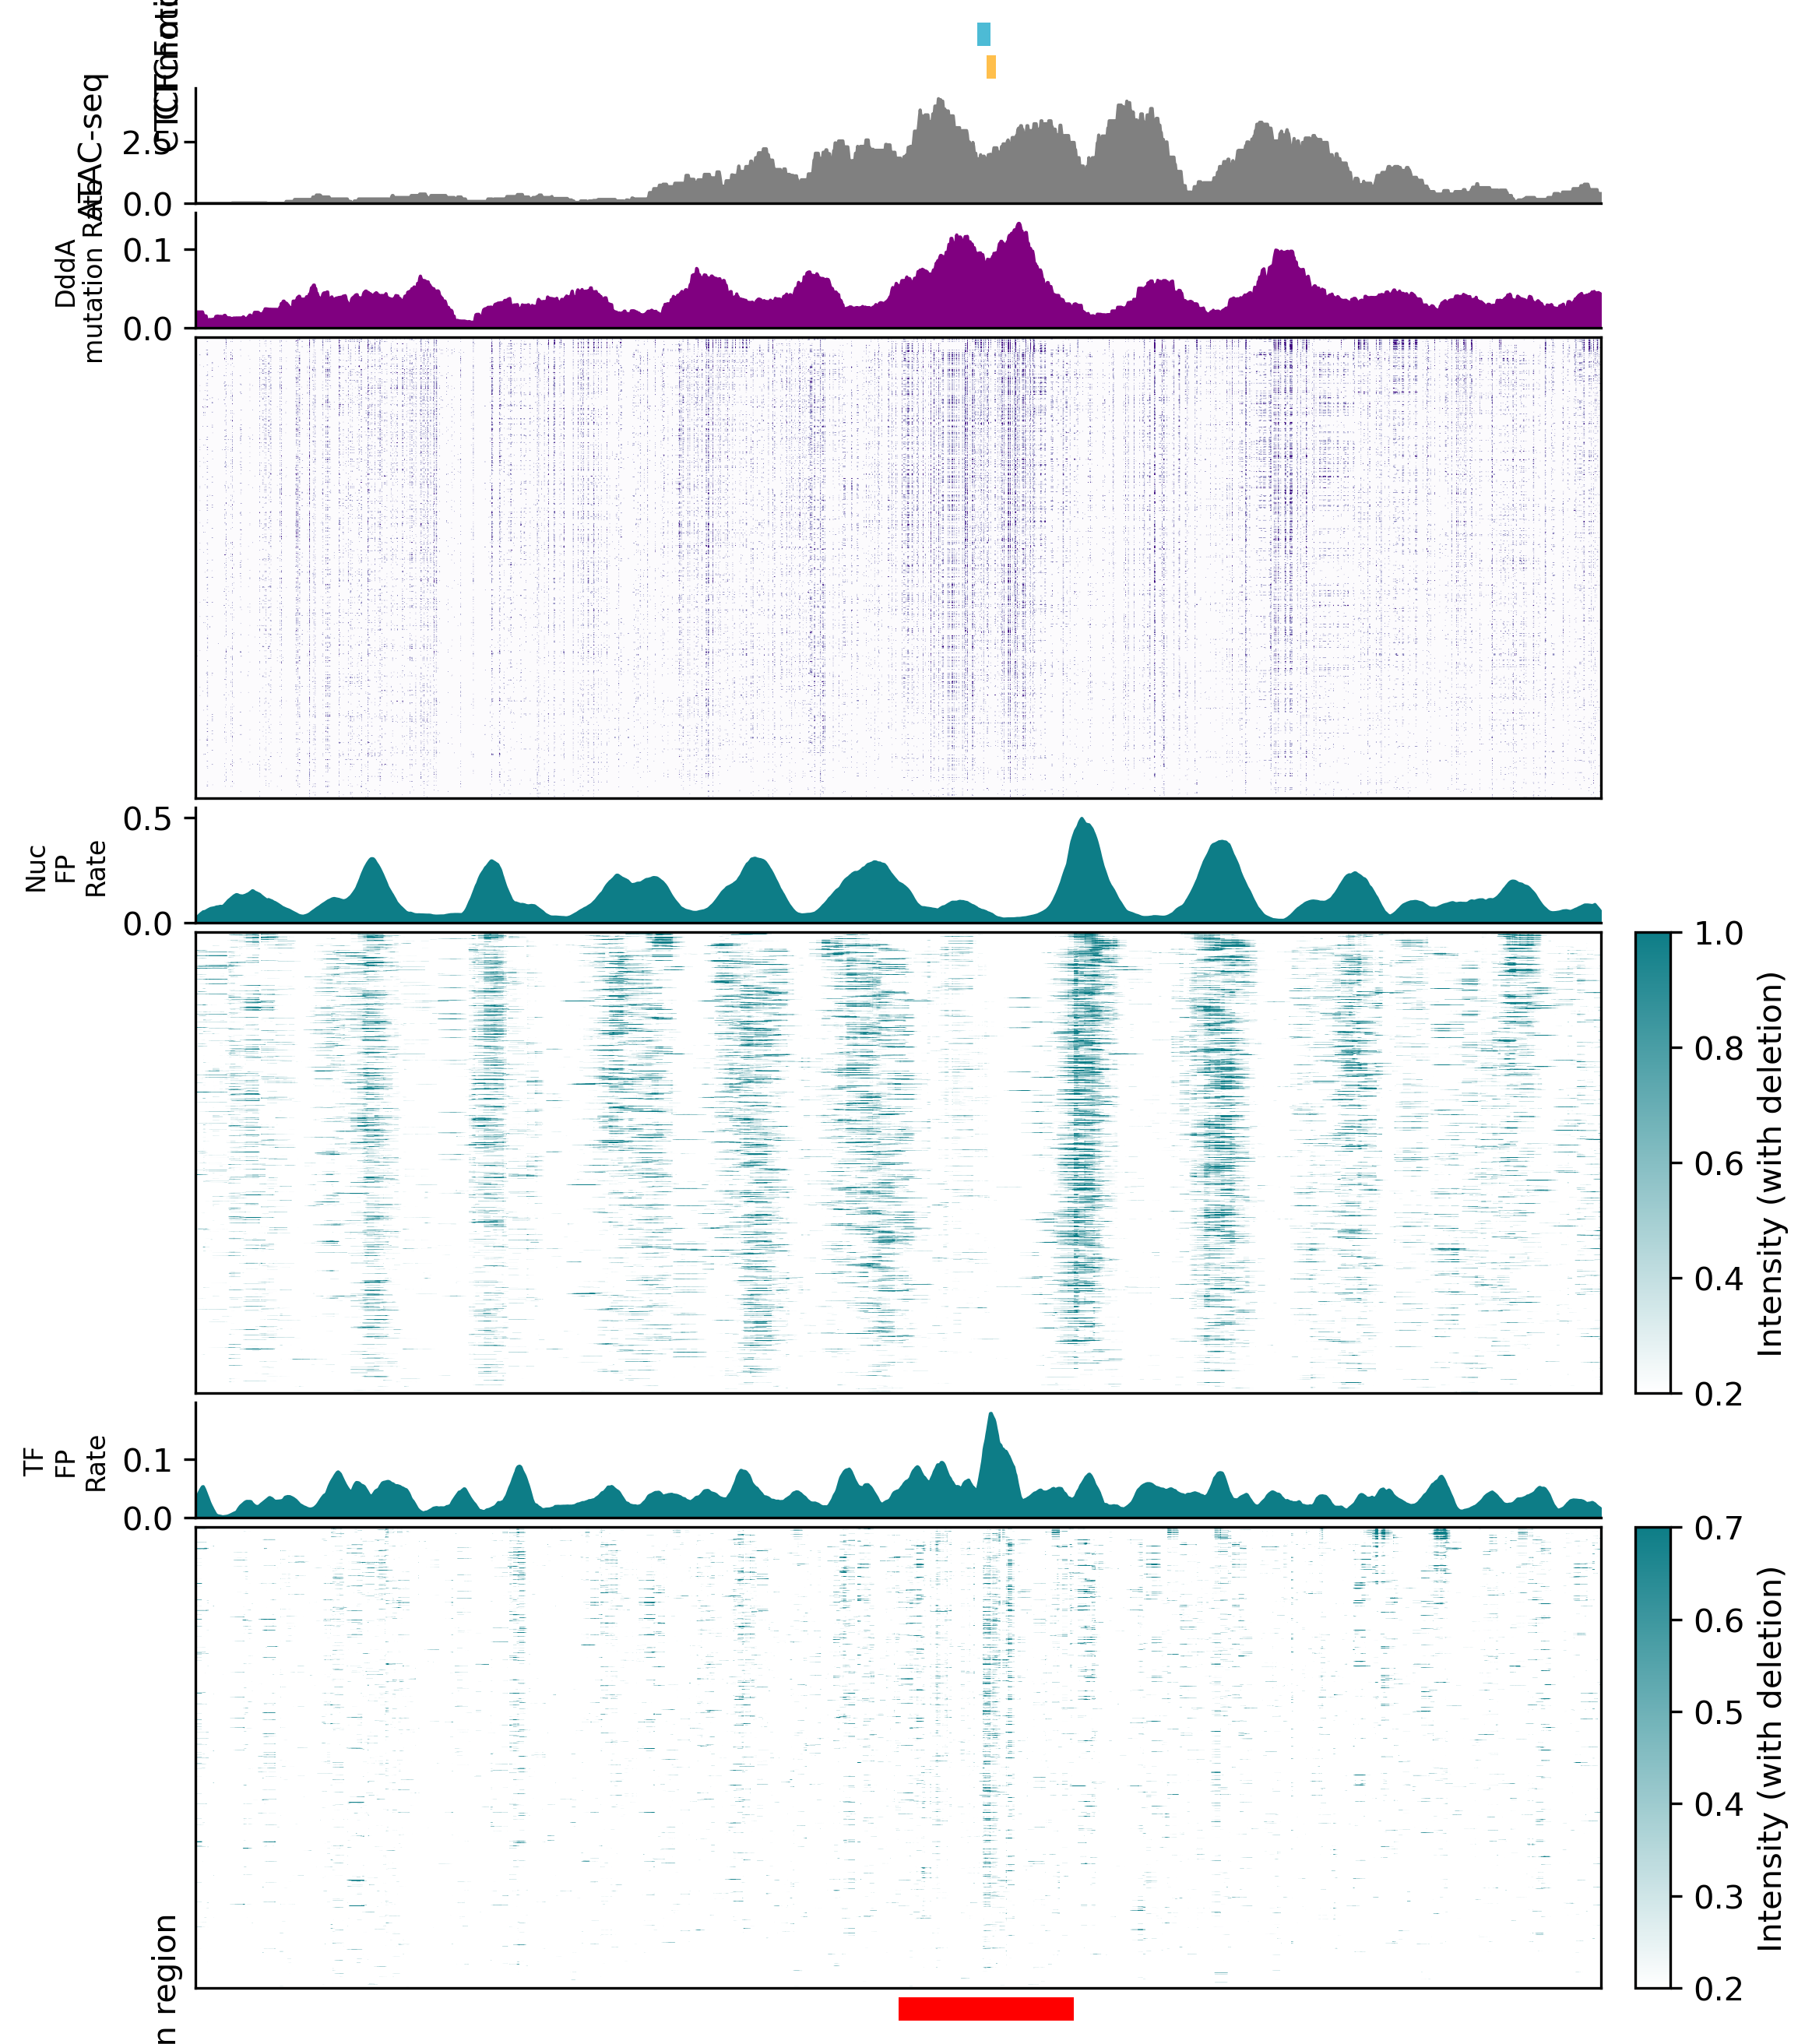

In [21]:
dark_green_cmap = LinearSegmentedColormap.from_list('dark_green', ['#FFFFFF', '#0d7d87'])
plot_range = np.arange(1500, 3500)
fig = plt.figure(dpi=300,figsize=(8, 8.853))
gs = GridSpec(10, 2, width_ratios=[20, 0.5], height_ratios=[0.1,0.1,0.5,0.5,2,0.5,2,0.5,2,0.1])

# Calculate average editing rate for each condition
track_deleted = np.mean(edits[np.array(selected_del_flags) == 1, :], axis=0)
track_undeleted = np.mean(edits[np.array(selected_del_flags) == 0, :], axis=0)

# Smooth tracks
track_deleted = np.convolve(track_deleted, np.ones(50), mode='same') / 50
track_undeleted = np.convolve(track_undeleted, np.ones(50), mode='same') / 50
track_deleted = track_deleted[plot_range]
track_undeleted = track_undeleted[plot_range]

ax5 = fig.add_subplot(gs[0, 0])
ax5.bar(CTCF_x_values_region, CTCF_values_region, color='#4dbbd5', alpha=1, width=1.0)
ax5.set_xlim([CTCF_x_values_region.min(), CTCF_x_values_region.max()])
ax5.set_ylim([0, 3])  # Set y-axis limits for the bar plot
ax5.set_xticks([])  # Remove x-axis ticks for the bar plot
ax5.set_yticks([])  # Remove y-axis ticks for the bar plot
ax5.set_ylabel('CTCFmotif')
ax5.spines['top'].set_visible(False)
ax5.spines['right'].set_visible(False)
ax5.spines['bottom'].set_visible(False)
ax5.spines['left'].set_visible(False)

ax5 = fig.add_subplot(gs[1, 0])
ax5.bar(YY1_x_values_region, YY1_values_region, color='orange', alpha=0.7, width=1.0)
ax5.set_xlim([YY1_x_values_region.min(), YY1_x_values_region.max()])
ax5.set_ylim([0, 3])  # Set y-axis limits for the bar plot
ax5.set_xticks([])  # Remove x-axis ticks for the bar plot
ax5.set_yticks([])  # Remove y-axis ticks for the bar plot
ax5.set_ylabel('CTCFmotif')
ax5.spines['top'].set_visible(False)
ax5.spines['right'].set_visible(False)
ax5.spines['bottom'].set_visible(False)
ax5.spines['left'].set_visible(False)

# New plot (Top plot)
ax2 = plt.subplot(gs[2,0])
ax2.fill_between(ATAC_x_values_plot, ATAC_y_values_convolve_plot, color='Grey', alpha=1)
ax2.set_xlim([ATAC_x_values_plot.min(), ATAC_x_values_plot.max()])
ax2.set_ylim([0, max(ATAC_y_values_convolve_plot) * 1.1])
ax2.set_xticks([])  # Remove x-axis ticks
ax2.set_xlabel('')
ax2.set_ylabel('ATAC-seq')

# Remove box outline and keep x and y axis
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

ax0 = plt.subplot(gs[3,0])
x_values = np.arange(len(track_undeleted))
ax0.fill_between(x_values, track_undeleted, color='purple', alpha=1)
ax0.set_xlim([x_values.min(), x_values.max()])
ax0.set_ylim([0, max(track_undeleted) * 1.1])
ax0.set_xticks([])  # Remove x-axis ticks
ax0.set_xlabel('')
ax0.set_ylabel('DddA\nmutation Rate', fontsize=8)

# Remove box outline and keep x and y axis
ax0.spines['top'].set_visible(False)
ax0.spines['right'].set_visible(False)


# Order reads by edit number
edits = np.array(ddda_data.edit_dict[locus][selected_read_inds, :].todense())
read_edit_num = np.sum(edits, axis=1)

# Plot footprints of reads with deletion
undel_filter = np.where(selected_del_flags == 0)[0]
row_order = [i for i in np.argsort(-read_edit_num) if i in undel_filter]
ax1 = fig.add_subplot(gs[4, 0])
ax1.imshow(edits[row_order, :][:, plot_range], aspect='auto', vmax=1, vmin=0, cmap="Purples")
ax1.tick_params(left=False, bottom=False)
ax1.xaxis.set_ticklabels([])
ax1.yaxis.set_ticklabels([])
ax1.spines['top'].set_visible(True)
ax1.spines['right'].set_visible(True)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)

# Plot average footprints across single reads
smooth_radius = 20

# Compute average footprints for reads with CRISPR deletions at the target site
track_deleted = np.mean(fp_nuc[selected_del_flags == 1, :][:, plot_range], axis=0)
track_deleted = np.convolve(track_deleted, np.ones(smooth_radius), mode="same") / smooth_radius

# Compute average footprints for reads without CRISPR deletions at the target site
track_undeleted = np.mean(fp_nuc[selected_del_flags == 0, :][:, plot_range], axis=0)
track_undeleted = np.convolve(track_undeleted, np.ones(smooth_radius), mode="same") / smooth_radius

ax2 = plt.subplot(gs[5,0])
x_values = np.arange(len(track_undeleted))
ax2.fill_between(x_values, track_undeleted, color='#0d7d87', alpha=1)
ax2.set_xlim([x_values.min(), x_values.max()])
ax2.set_ylim([0, max(track_undeleted) * 1.1])
ax2.set_xticks([])  # Remove x-axis ticks
ax2.set_xlabel('')
ax2.set_ylabel('Nuc\nFP\nRate', fontsize=8)

# Remove box outline and keep x and y axis
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)


# Plot footprints of reads with deletion
ax3 = fig.add_subplot(gs[6, 0])
im3 = ax3.imshow(fp_nuc[row_order, :][:, plot_range], aspect='auto', vmax=1, vmin=0.2, cmap=dark_green_cmap)
ax3.tick_params(left=False, bottom=False)
ax3.xaxis.set_ticklabels([])
ax3.yaxis.set_ticklabels([])
ax3.spines['top'].set_visible(True)
ax3.spines['right'].set_visible(True)
ax3.spines['bottom'].set_visible(True)
ax3.spines['left'].set_visible(True)

# Create a separate axis for the colorbar for ax3
cbar3 = fig.add_subplot(gs[6, 1])
fig.colorbar(im3, cax=cbar3)
cbar3.set_ylabel('Intensity (with deletion)')

# Compute average footprints for reads with CRISPR deletions at the target site
track_deleted = np.mean(fp_tf[selected_del_flags == 1, :][:, plot_range], axis=0)
track_deleted = np.convolve(track_deleted, np.ones(smooth_radius), mode="same") / smooth_radius

# Compute average footprints for reads without CRISPR deletions at the target site
track_undeleted = np.mean(fp_tf[selected_del_flags == 0, :][:, plot_range], axis=0)
track_undeleted = np.convolve(track_undeleted, np.ones(smooth_radius), mode="same") / smooth_radius

ax4 = plt.subplot(gs[7,0])
x_values = np.arange(len(track_undeleted))
ax4.fill_between(x_values, track_undeleted, color='#0d7d87', alpha=1)
ax4.set_xlim([x_values.min(), x_values.max()])
ax4.set_ylim([0, max(track_undeleted) * 1.1])
ax4.set_xticks([])  # Remove x-axis ticks
ax4.set_xlabel('')
ax4.set_ylabel('TF\nFP\nRate', fontsize=8)

# Remove box outline and keep x and y axis
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)

ax5 = fig.add_subplot(gs[8, 0])
im5 = ax5.imshow(fp_tf[row_order, :][:, plot_range], aspect='auto', vmax=0.7, vmin=0.2, cmap=dark_green_cmap)
ax5.tick_params(left=False, bottom=False)
ax5.xaxis.set_ticklabels([])
ax5.yaxis.set_ticklabels([])
ax5.spines['top'].set_visible(True)
ax5.spines['right'].set_visible(True)
ax5.spines['bottom'].set_visible(True)
ax5.spines['left'].set_visible(True)

# Create a separate axis for the colorbar for ax3
cbar5 = fig.add_subplot(gs[8, 1])
fig.colorbar(im5, cax=cbar5)
cbar5.set_ylabel('Intensity (with deletion)')

ax5 = fig.add_subplot(gs[9, 0])
ax5.bar(open_x_values_region, open_values_region, color='red', alpha=1, width=1.0)
ax5.set_xlim([open_x_values_region.min(), open_x_values_region.max()])
ax5.set_ylim([0, 3])  # Set y-axis limits for the bar plot
ax5.set_xticks([])  # Remove x-axis ticks for the bar plot
ax5.set_yticks([])  # Remove y-axis ticks for the bar plot
ax5.set_ylabel('open region')
ax5.spines['top'].set_visible(False)
ax5.spines['right'].set_visible(False)
ax5.spines['bottom'].set_visible(False)
ax5.spines['left'].set_visible(False)


# Adjust layout to make sure plots don't overlap
plt.tight_layout()
plt.subplots_adjust(hspace=0.05, right=0.9) 
# Save the combined figure
#plt.savefig(os.path.join(plot_dir, "HJR235_undeleted_2623-2645_YY1_openregion.pdf"))
plt.show()

In [22]:
#sgRNA barplot
data_x_values = np.arange(ref_range_dict[locus][1], ref_range_dict[locus][2]+1)
bar_values = np.zeros_like(data_x_values)
bar_values[(data_x_values >= 27161138) & (data_x_values < 27161157)] = 3  # Adjust indices as needed
bar_values_region=bar_values[plot_range]
data_x_values_region=data_x_values[plot_range]

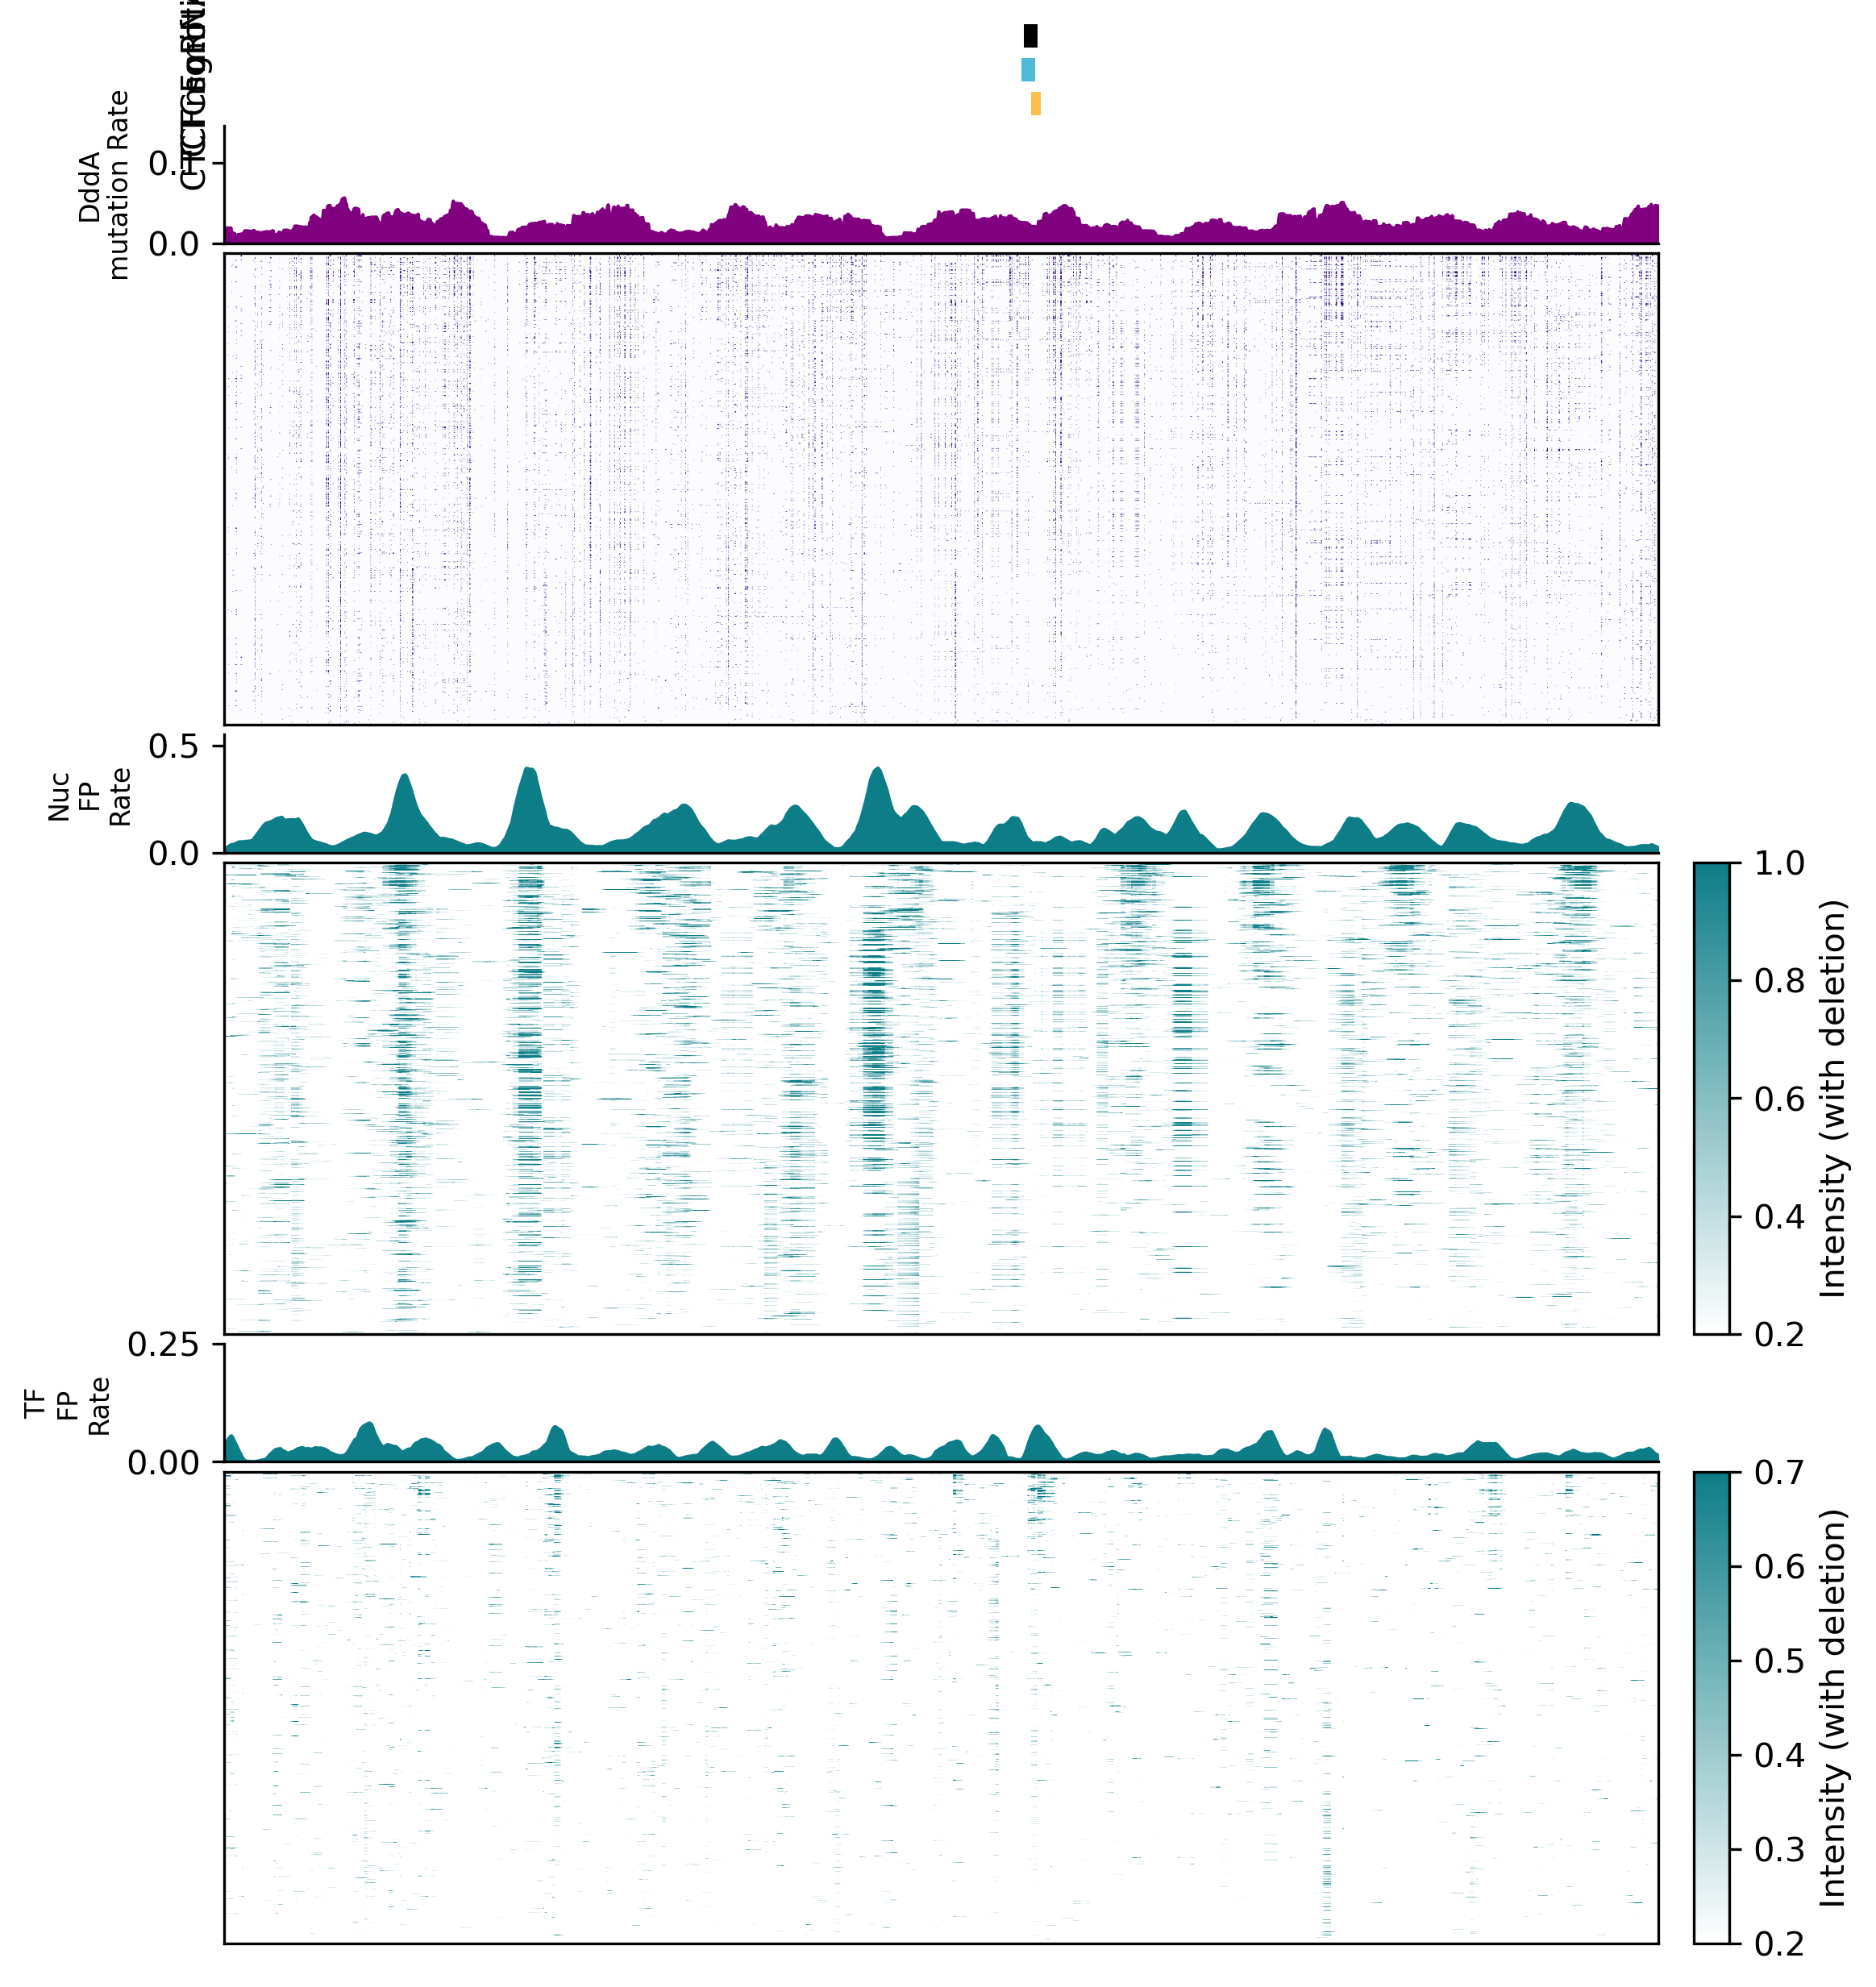

In [23]:
plot_range = np.arange(1500, 3500)
fig = plt.figure(dpi=300,figsize=(8, 8.317))
gs = GridSpec(9, 2, width_ratios=[20, 0.5], height_ratios=[0.1,0.1, 0.1, 0.5,2,0.5,2,0.5,2])

ax4 = fig.add_subplot(gs[0, 0])
ax4.bar(data_x_values_region, bar_values_region, color='black', alpha=1, width=1.0)
ax4.set_xlim([data_x_values_region.min(), data_x_values_region.max()])
ax4.set_ylim([0, 3])  # Set y-axis limits for the bar plot
ax4.set_xticks([])  # Remove x-axis ticks for the bar plot
ax4.set_yticks([])  # Remove y-axis ticks for the bar plot
ax4.set_ylabel('sgRNA')
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.spines['bottom'].set_visible(False)
ax4.spines['left'].set_visible(False)

ax5 = fig.add_subplot(gs[1, 0])
ax5.bar(CTCF_x_values_region, CTCF_values_region, color='#4dbbd5', alpha=1, width=1.0)
ax5.set_xlim([CTCF_x_values_region.min(), CTCF_x_values_region.max()])
ax5.set_ylim([0, 3])  # Set y-axis limits for the bar plot
ax5.set_xticks([])  # Remove x-axis ticks for the bar plot
ax5.set_yticks([])  # Remove y-axis ticks for the bar plot
ax5.set_ylabel('CTCFmotif')
ax5.spines['top'].set_visible(False)
ax5.spines['right'].set_visible(False)
ax5.spines['bottom'].set_visible(False)
ax5.spines['left'].set_visible(False)

ax5 = fig.add_subplot(gs[2, 0])
ax5.bar(YY1_x_values_region, YY1_values_region, color='orange', alpha=0.7, width=1.0)
ax5.set_xlim([YY1_x_values_region.min(), YY1_x_values_region.max()])
ax5.set_ylim([0, 3])  # Set y-axis limits for the bar plot
ax5.set_xticks([])  # Remove x-axis ticks for the bar plot
ax5.set_yticks([])  # Remove y-axis ticks for the bar plot
ax5.set_ylabel('CTCFmotif')
ax5.spines['top'].set_visible(False)
ax5.spines['right'].set_visible(False)
ax5.spines['bottom'].set_visible(False)
ax5.spines['left'].set_visible(False)


# Calculate average editing rate for each condition
track_deleted = np.mean(edits[np.array(selected_del_flags) == 1, :], axis=0)
track_undeleted = np.mean(edits[np.array(selected_del_flags) == 0, :], axis=0)

# Smooth tracks
track_deleted = np.convolve(track_deleted, np.ones(50), mode='same') / 50
track_undeleted = np.convolve(track_undeleted, np.ones(50), mode='same') / 50
track_deleted = track_deleted[plot_range]
track_undeleted = track_undeleted[plot_range]

ax0 = plt.subplot(gs[3,0])
x_values = np.arange(len(track_deleted))
ax0.fill_between(x_values, track_deleted, color='purple', alpha=1)
ax0.set_xlim([x_values.min(), x_values.max()])
ax0.set_ylim([0, max(track_undeleted) * 1.1])
ax0.set_xticks([])  # Remove x-axis ticks
ax0.set_xlabel('')
ax0.set_ylabel('DddA\nmutation Rate', fontsize=8)

# Remove box outline and keep x and y axis
ax0.spines['top'].set_visible(False)
ax0.spines['right'].set_visible(False)


# Order reads by edit number
edits = np.array(ddda_data.edit_dict[locus][selected_read_inds, :].todense())
read_edit_num = np.sum(edits, axis=1)

# Plot footprints of reads with deletion
undel_filter = np.where(selected_del_flags == 1)[0]
row_order = [i for i in np.argsort(-read_edit_num) if i in undel_filter]
ax1 = fig.add_subplot(gs[4, 0])
ax1.imshow(edits[row_order, :][:, plot_range], aspect='auto', vmax=1, vmin=0, cmap="Purples")
ax1.tick_params(left=False, bottom=False)
ax1.xaxis.set_ticklabels([])
ax1.yaxis.set_ticklabels([])
ax1.spines['top'].set_visible(True)
ax1.spines['right'].set_visible(True)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)

# Plot average footprints across single reads
smooth_radius = 20

# Compute average footprints for reads with CRISPR deletions at the target site
track_deleted = np.mean(fp_nuc[selected_del_flags == 1, :][:, plot_range], axis=0)
track_deleted = np.convolve(track_deleted, np.ones(smooth_radius), mode="same") / smooth_radius

# Compute average footprints for reads without CRISPR deletions at the target site
track_undeleted = np.mean(fp_nuc[selected_del_flags == 0, :][:, plot_range], axis=0)
track_undeleted = np.convolve(track_undeleted, np.ones(smooth_radius), mode="same") / smooth_radius

ax2 = plt.subplot(gs[5,0])
x_values = np.arange(len(track_deleted))
ax2.fill_between(x_values, track_deleted, color='#0d7d87', alpha=1)
ax2.set_xlim([x_values.min(), x_values.max()])
ax2.set_ylim([0, max(track_undeleted) * 1.1])
ax2.set_xticks([])  # Remove x-axis ticks
ax2.set_xlabel('')
ax2.set_ylabel('Nuc\nFP\nRate', fontsize=8)

# Remove box outline and keep x and y axis
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)


# Plot footprints of reads with deletion
ax3 = fig.add_subplot(gs[6, 0])
im3 = ax3.imshow(fp_nuc[row_order, :][:, plot_range], aspect='auto', vmax=1, vmin=0.2, cmap=dark_green_cmap)
ax3.tick_params(left=False, bottom=False)
ax3.xaxis.set_ticklabels([])
ax3.yaxis.set_ticklabels([])
ax3.spines['top'].set_visible(True)
ax3.spines['right'].set_visible(True)
ax3.spines['bottom'].set_visible(True)
ax3.spines['left'].set_visible(True)

# Create a separate axis for the colorbar for ax3
cbar3 = fig.add_subplot(gs[6, 1])
fig.colorbar(im3, cax=cbar3)
cbar3.set_ylabel('Intensity (with deletion)')

# Compute average footprints for reads with CRISPR deletions at the target site
track_deleted = np.mean(fp_tf[selected_del_flags == 1, :][:, plot_range], axis=0)
track_deleted = np.convolve(track_deleted, np.ones(smooth_radius), mode="same") / smooth_radius

# Compute average footprints for reads without CRISPR deletions at the target site
track_undeleted = np.mean(fp_tf[selected_del_flags == 0, :][:, plot_range], axis=0)
track_undeleted = np.convolve(track_undeleted, np.ones(smooth_radius), mode="same") / smooth_radius

ax4 = plt.subplot(gs[7,0])
x_values = np.arange(len(track_deleted))
ax4.fill_between(x_values, track_deleted, color='#0d7d87', alpha=1)
ax4.set_xlim([x_values.min(), x_values.max()])
ax4.set_ylim([0, 0.25])
ax4.set_xticks([])  # Remove x-axis ticks
ax4.set_xlabel('')
ax4.set_ylabel('TF\nFP\nRate', fontsize=8)

# Remove box outline and keep x and y axis
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)

ax5 = fig.add_subplot(gs[8, 0])
im5 = ax5.imshow(fp_tf[row_order, :][:, plot_range], aspect='auto', vmax=0.7, vmin=0.2, cmap=dark_green_cmap)
ax5.tick_params(left=False, bottom=False)
ax5.xaxis.set_ticklabels([])
ax5.yaxis.set_ticklabels([])
ax5.spines['top'].set_visible(True)
ax5.spines['right'].set_visible(True)
ax5.spines['bottom'].set_visible(True)
ax5.spines['left'].set_visible(True)

# Create a separate axis for the colorbar for ax3
cbar5 = fig.add_subplot(gs[8, 1])
fig.colorbar(im5, cax=cbar5)
cbar5.set_ylabel('Intensity (with deletion)')

# Adjust layout to make sure plots don't overlap
plt.tight_layout()
plt.subplots_adjust(hspace=0.05, right=0.9) 
# Save the combined figure
#plt.savefig(os.path.join(plot_dir, "HJR235_deleted_2623-2645_YY1.pdf"))
plt.show()

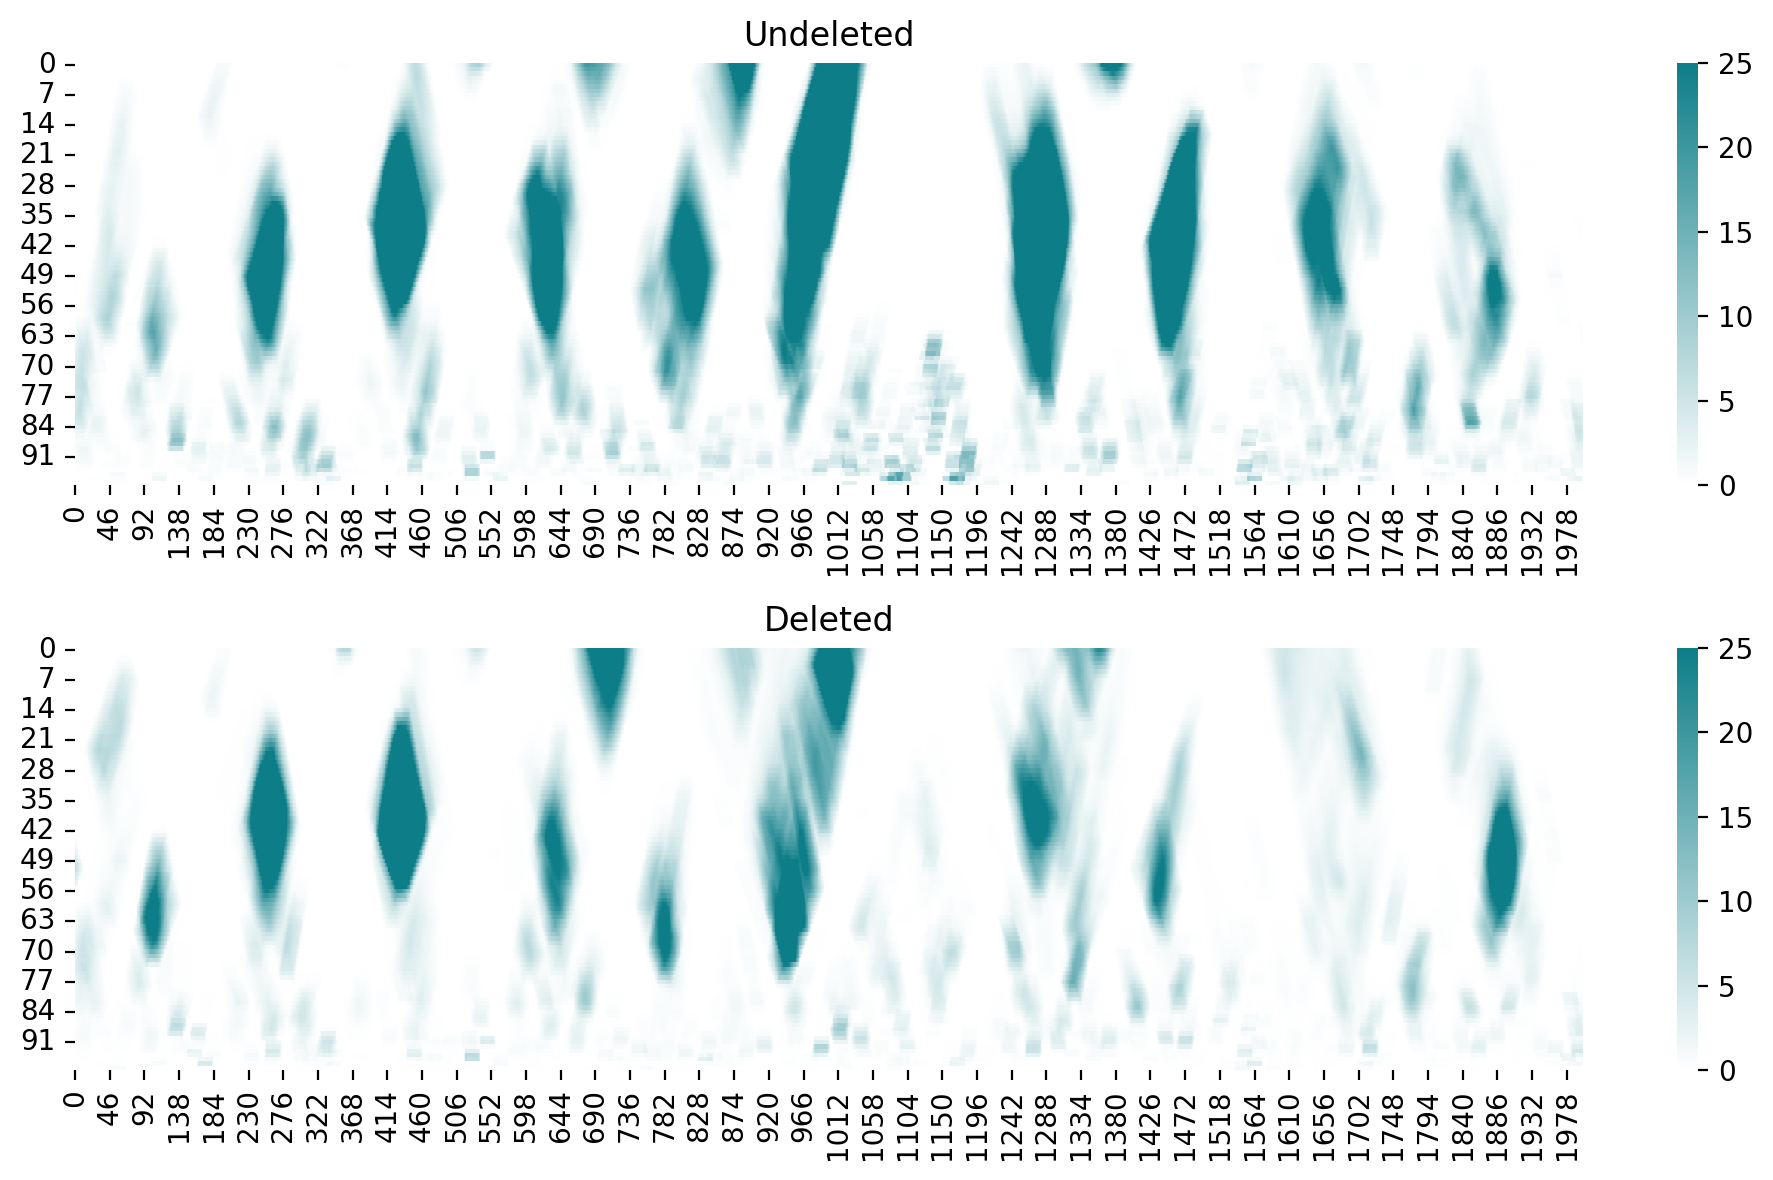

In [24]:
#version2
footprint_dict = {}

for mode in ["del", "undel"]:
    read_inds = eval(mode + "_read_inds")
    footprint_dict[mode] = {}
    for strand_ind in range(2):

        # Get bias and edits on the selected strand
        strands = ddda_data.read_strands[locus][read_inds]
        bias = ddda_data.bias_dict[locus][:, strand_ind]
        agg_edits = np.array(np.sum(ddda_data.edit_dict[locus][read_inds[strands == strand_ind], :], axis=0))[0, :]
    
        # We mask the vicinity of the guide since the deletions might affect footprint calling
        agg_edits[del_start:del_end] = 0
        bias[del_start:del_end] = 0
    
        # Calculate footprints
        smooth_radius = 20
        footprints = np.array([get_footprint_single_scale(
            agg_edits, bias, fp_radius=r, combine_sides="max_pval") for r in np.arange(2, 100)])
        footprints = -np.log10(footprints + 1e-300)
        footprints = np.array([
            np.convolve(footprints[i, :], np.ones(smooth_radius)) / (2 * smooth_radius) \
            for i in np.arange(footprints.shape[0])])
        footprint_dict[mode][strand_ind] = footprints

undel_footprint = np.flip(footprint_dict["undel"][0][:, plot_range] +
                          footprint_dict["undel"][1][:, plot_range], axis=0)
del_footprint = np.flip(footprint_dict["del"][0][:, plot_range] +
                        footprint_dict["del"][1][:, plot_range], axis=0)
fig, axes = plt.subplots(2, 1, dpi=200, figsize=(10,6))
sns.heatmap(
    ax=axes[0], 
    data = undel_footprint,
    vmax=25, cmap = dark_green_cmap)
sns.heatmap(
    ax=axes[1], 
    data = del_footprint, 
    vmax=25, cmap = dark_green_cmap)
axes[0].set_title("Undeleted")
axes[1].set_title("Deleted")
plt.tight_layout()
#plt.savefig(os.path.join(plot_dir, "multi_scale_footprints_green_v2_2620-2650.pdf"))
plt.show()

Per base motif analysis

In [25]:
# Initialize lists to store results
mut_del = []
mut_undel = []
mut_readnum = []

for motif_start in range(2565, 2644):
    motif_end = motif_start + 60
    print(motif_start)
    
    # Find reads where the target(motif) site is covered by a deletion
    del_start, del_end = motif_start+30, motif_start+31
    del_matrix = ddda_data.del_dict[locus]
    motif_del = np.array(np.max(del_matrix[:, del_start:del_end], axis=1).todense())[:, 0]
    length_del = np.array(np.sum(del_matrix[:, motif_start:motif_end], axis=1))[:, 0]
    del_read_inds = np.where((motif_del == 1) & (length_del >5))[0]

    # Only keep reads where positions outside of the vicinity of the target site are not deleted
    upstream_del = np.array(np.max(del_matrix[:, :del_start-12], axis=1).todense())[:, 0]
    downstream_del = np.array(np.max(del_matrix[:, del_end+12:], axis=1).todense())[:, 0]
    upstream_filter = upstream_del == 0
    downstream_filter = downstream_del == 0
    filter = np.where(upstream_filter & downstream_filter)[0]
    del_read_inds = np.intersect1d(del_read_inds, filter)

    # Find reads without any deletion as a control
    undel_read_inds = np.where(np.array(np.max(del_matrix, axis=1).todense())[:, 0] == 0)[0]

    # Down-sample the number of reads
    min_num = min(len(del_read_inds), len(undel_read_inds), 10000)
    del_read_inds = np.random.choice(del_read_inds, min_num, replace=False)
    undel_read_inds = np.random.choice(undel_read_inds, min_num, replace=False)
        

    # De-duplicate reads
    del_read_ids = ddda_data.dedup_reads(
        locus=locus, 
        read_ids=np.array(ddda_data.read_ids[locus])[del_read_inds]
    )
    undel_read_ids = ddda_data.dedup_reads(
        locus=locus, 
        read_ids=np.array(ddda_data.read_ids[locus])[undel_read_inds]
    )
    del_read_inds = np.array([ddda_data.read_ids[locus].index(i) for i in del_read_ids])
    undel_read_inds = np.array([ddda_data.read_ids[locus].index(i) for i in undel_read_ids])

    # Combine deleted and undeleted reads
    selected_read_inds = np.concatenate([del_read_inds, undel_read_inds])
    selected_reads = np.array(ddda_data.read_ids[locus])[selected_read_inds]
    selected_del_flags = np.concatenate([np.ones(len(del_read_inds)), np.zeros(len(undel_read_inds))])
    selection_dict = {"HJR235": selected_reads}

    edits = np.array(ddda_data.edit_dict[locus][selected_read_inds, :].todense())

    # Calculate average editing rate for each condition
    track_deleted = np.mean(edits[np.array(selected_del_flags) == 1, :], axis=0)
    track_undeleted = np.mean(edits[np.array(selected_del_flags) == 0, :], axis=0)
    
    # Exclude the target site when counting the edits
    exclude_range = np.arange(motif_start, motif_end)
    analysis_indices = np.setdiff1d(plot_range[np.arange(1000, 1250)], exclude_range)
    mean_deleted_excluded = np.mean(track_deleted[analysis_indices])
    mean_undeleted_excluded = np.mean(track_undeleted[analysis_indices])

    # Store the means and read numbers for the current motif start
    mut_del.append({"motif_start": del_start, "mean_deleted": mean_deleted_excluded})
    mut_undel.append({"motif_start": del_start, "mean_undeleted": mean_undeleted_excluded})
    mut_readnum.append({"motif_start": del_start, "read_number": len(del_read_inds)})

# Convert results to DataFrame
mut_df = (
    pd.DataFrame(mut_del)
    .merge(pd.DataFrame(mut_undel), on="motif_start")
    .merge(pd.DataFrame(mut_readnum), on="motif_start")
)

# Display the resulting DataFrame
mut_df.head()


2565


100%|██████████| 24/24 [00:00<00:00, 5748.90it/s]
24it [00:00, 279620.27it/s]
100%|██████████| 24/24 [00:00<00:00, 5593.34it/s]
24it [00:00, 242562.16it/s]


2566


100%|██████████| 25/25 [00:00<00:00, 5703.43it/s]
25it [00:00, 222627.60it/s]
100%|██████████| 25/25 [00:00<00:00, 5628.13it/s]
25it [00:00, 256375.55it/s]


2567


100%|██████████| 22/22 [00:00<00:00, 5592.07it/s]
22it [00:00, 292008.51it/s]
100%|██████████| 22/22 [00:00<00:00, 5663.80it/s]
22it [00:00, 257032.56it/s]


2568


100%|██████████| 19/19 [00:00<00:00, 5518.82it/s]
19it [00:00, 211384.02it/s]
100%|██████████| 19/19 [00:00<00:00, 4094.32it/s]
19it [00:00, 224483.88it/s]


2569


100%|██████████| 18/18 [00:00<00:00, 5431.86it/s]
18it [00:00, 218200.79it/s]
100%|██████████| 18/18 [00:00<00:00, 4122.17it/s]
18it [00:00, 220752.84it/s]


2570


100%|██████████| 15/15 [00:00<00:00, 5316.42it/s]
15it [00:00, 185588.67it/s]
100%|██████████| 15/15 [00:00<00:00, 3742.02it/s]
15it [00:00, 208326.36it/s]


2571


100%|██████████| 18/18 [00:00<00:00, 5327.60it/s]
18it [00:00, 175984.78it/s]
100%|██████████| 18/18 [00:00<00:00, 5448.33it/s]
18it [00:00, 222706.41it/s]


2572


100%|██████████| 20/20 [00:00<00:00, 5521.00it/s]
20it [00:00, 237637.62it/s]
100%|██████████| 20/20 [00:00<00:00, 5703.04it/s]
20it [00:00, 238312.73it/s]


2573


100%|██████████| 18/18 [00:00<00:00, 5400.01it/s]
18it [00:00, 197637.36it/s]
100%|██████████| 18/18 [00:00<00:00, 4542.29it/s]
18it [00:00, 206842.39it/s]


2574


100%|██████████| 15/15 [00:00<00:00, 5301.19it/s]
15it [00:00, 215460.82it/s]
100%|██████████| 15/15 [00:00<00:00, 5236.77it/s]
15it [00:00, 216946.76it/s]


2575


100%|██████████| 20/20 [00:00<00:00, 5489.93it/s]
20it [00:00, 245280.94it/s]
100%|██████████| 20/20 [00:00<00:00, 5498.56it/s]
20it [00:00, 212369.82it/s]


2576


100%|██████████| 25/25 [00:00<00:00, 5719.92it/s]
25it [00:00, 273066.67it/s]
100%|██████████| 25/25 [00:00<00:00, 4576.94it/s]
25it [00:00, 288863.91it/s]


2577


100%|██████████| 25/25 [00:00<00:00, 5708.09it/s]
25it [00:00, 283398.92it/s]
100%|██████████| 25/25 [00:00<00:00, 5650.26it/s]
25it [00:00, 270949.87it/s]


2578


100%|██████████| 23/23 [00:00<00:00, 5677.32it/s]
23it [00:00, 263576.48it/s]
100%|██████████| 23/23 [00:00<00:00, 5501.51it/s]
23it [00:00, 260727.01it/s]


2579


100%|██████████| 33/33 [00:00<00:00, 5844.86it/s]
33it [00:00, 335138.09it/s]
100%|██████████| 33/33 [00:00<00:00, 5776.07it/s]
33it [00:00, 340916.33it/s]


2580


100%|██████████| 33/33 [00:00<00:00, 5871.63it/s]
33it [00:00, 348644.92it/s]
100%|██████████| 33/33 [00:00<00:00, 5784.04it/s]
33it [00:00, 302209.68it/s]


2581


100%|██████████| 31/31 [00:00<00:00, 5812.92it/s]
31it [00:00, 314066.24it/s]
100%|██████████| 31/31 [00:00<00:00, 5070.13it/s]
31it [00:00, 288940.94it/s]


2582


100%|██████████| 38/38 [00:00<00:00, 5903.97it/s]
38it [00:00, 368943.41it/s]
100%|██████████| 38/38 [00:00<00:00, 5860.12it/s]
38it [00:00, 384056.75it/s]


2583


100%|██████████| 37/37 [00:00<00:00, 5870.15it/s]
37it [00:00, 362591.70it/s]
100%|██████████| 37/37 [00:00<00:00, 5905.90it/s]
37it [00:00, 375760.89it/s]


2584


100%|██████████| 76/76 [00:00<00:00, 6102.67it/s]
76it [00:00, 579576.55it/s]
100%|██████████| 76/76 [00:00<00:00, 6121.78it/s]
76it [00:00, 572292.83it/s]


2585


100%|██████████| 70/70 [00:00<00:00, 6102.71it/s]
70it [00:00, 567894.16it/s]
100%|██████████| 70/70 [00:00<00:00, 6101.69it/s]
70it [00:00, 499321.90it/s]


2586


100%|██████████| 73/73 [00:00<00:00, 6073.28it/s]
73it [00:00, 578798.09it/s]
100%|██████████| 73/73 [00:00<00:00, 6092.01it/s]
73it [00:00, 548717.19it/s]


2587


100%|██████████| 79/79 [00:00<00:00, 6151.95it/s]
79it [00:00, 577264.84it/s]
100%|██████████| 79/79 [00:00<00:00, 6102.88it/s]
79it [00:00, 601361.19it/s]


2588


100%|██████████| 73/73 [00:00<00:00, 6115.24it/s]
73it [00:00, 503592.42it/s]
100%|██████████| 73/73 [00:00<00:00, 6076.05it/s]
73it [00:00, 516330.85it/s]


2589


100%|██████████| 89/89 [00:00<00:00, 6183.52it/s]
89it [00:00, 626330.63it/s]
100%|██████████| 89/89 [00:00<00:00, 6120.76it/s]
89it [00:00, 629499.25it/s]


2590


100%|██████████| 150/150 [00:00<00:00, 6274.01it/s]
150it [00:00, 851347.23it/s]
100%|██████████| 150/150 [00:00<00:00, 6286.74it/s]
150it [00:00, 810754.64it/s]


2591


100%|██████████| 833/833 [00:00<00:00, 6420.26it/s]
833it [00:00, 1143651.47it/s]
100%|██████████| 833/833 [00:00<00:00, 6412.66it/s]
833it [00:00, 1121983.05it/s]


2592


100%|██████████| 846/846 [00:00<00:00, 6385.74it/s]
846it [00:00, 1159222.86it/s]
100%|██████████| 846/846 [00:00<00:00, 6439.73it/s]
846it [00:00, 1153195.05it/s]


2593


100%|██████████| 1607/1607 [00:00<00:00, 6442.06it/s]
1607it [00:00, 1288519.70it/s]
100%|██████████| 1607/1607 [00:00<00:00, 6453.30it/s]
1607it [00:00, 1220616.90it/s]


2594


100%|██████████| 1628/1628 [00:00<00:00, 6456.33it/s]
1628it [00:00, 1250609.32it/s]
100%|██████████| 1628/1628 [00:00<00:00, 6419.59it/s]
1628it [00:00, 1283037.75it/s]


2595


100%|██████████| 1816/1816 [00:00<00:00, 6469.39it/s]
1816it [00:00, 1261068.88it/s]
100%|██████████| 1816/1816 [00:00<00:00, 6420.86it/s]
1816it [00:00, 1197054.23it/s]


2596


100%|██████████| 1992/1992 [00:00<00:00, 6458.75it/s]
1992it [00:00, 1263237.61it/s]
100%|██████████| 1992/1992 [00:00<00:00, 6384.92it/s]
1992it [00:00, 1250195.06it/s]


2597


100%|██████████| 2031/2031 [00:00<00:00, 6466.59it/s]
2031it [00:00, 1259779.86it/s]
100%|██████████| 2031/2031 [00:00<00:00, 6412.59it/s]
2031it [00:00, 1257733.86it/s]


2598


100%|██████████| 2654/2654 [00:00<00:00, 6471.66it/s]
2654it [00:00, 1236991.09it/s]
100%|██████████| 2654/2654 [00:00<00:00, 6464.03it/s]
2654it [00:00, 1233700.86it/s]


2599


100%|██████████| 2679/2679 [00:00<00:00, 6482.77it/s]
2679it [00:00, 1202669.42it/s]
100%|██████████| 2679/2679 [00:00<00:00, 6420.76it/s]
2679it [00:00, 1151874.98it/s]


2600


100%|██████████| 3123/3123 [00:00<00:00, 6462.20it/s]
3123it [00:00, 1234339.56it/s]
100%|██████████| 3123/3123 [00:00<00:00, 6440.95it/s]
3123it [00:00, 1250960.88it/s]


2601


100%|██████████| 3506/3506 [00:00<00:00, 6489.04it/s]
3506it [00:00, 1316964.88it/s]
100%|██████████| 3506/3506 [00:00<00:00, 6426.02it/s]
3506it [00:00, 1219440.24it/s]


2602


100%|██████████| 3515/3515 [00:00<00:00, 6483.24it/s]
3515it [00:00, 1183984.79it/s]
100%|██████████| 3515/3515 [00:00<00:00, 6468.99it/s]
3515it [00:00, 1234548.53it/s]


2603


100%|██████████| 2006/2006 [00:00<00:00, 6480.26it/s]
2006it [00:00, 1299223.88it/s]
100%|██████████| 2006/2006 [00:00<00:00, 6393.19it/s]
2006it [00:00, 1256537.31it/s]


2604


100%|██████████| 2010/2010 [00:00<00:00, 6435.93it/s]
2010it [00:00, 1264898.88it/s]
100%|██████████| 2010/2010 [00:00<00:00, 6426.74it/s]
2010it [00:00, 1207469.36it/s]


2605


100%|██████████| 2256/2256 [00:00<00:00, 6466.75it/s]
2256it [00:00, 991860.57it/s]
100%|██████████| 2256/2256 [00:00<00:00, 6456.91it/s]
2256it [00:00, 1277487.49it/s]


2606


100%|██████████| 2202/2202 [00:00<00:00, 6422.95it/s]
2202it [00:00, 1233750.66it/s]
100%|██████████| 2202/2202 [00:00<00:00, 6391.96it/s]
2202it [00:00, 1281512.06it/s]


2607


100%|██████████| 1361/1361 [00:00<00:00, 6421.66it/s]
1361it [00:00, 1227359.22it/s]
100%|██████████| 1361/1361 [00:00<00:00, 6393.63it/s]
1361it [00:00, 1121722.88it/s]


2608


100%|██████████| 2227/2227 [00:00<00:00, 6511.26it/s]
2227it [00:00, 1286068.43it/s]
100%|██████████| 2227/2227 [00:00<00:00, 6445.65it/s]
2227it [00:00, 1250430.39it/s]


2609


100%|██████████| 2190/2190 [00:00<00:00, 6494.67it/s]
2190it [00:00, 1230314.19it/s]
100%|██████████| 2190/2190 [00:00<00:00, 6449.02it/s]
2190it [00:00, 1260190.12it/s]


2610


100%|██████████| 1696/1696 [00:00<00:00, 6469.92it/s]
1696it [00:00, 1290320.98it/s]
100%|██████████| 1696/1696 [00:00<00:00, 6438.31it/s]
1696it [00:00, 1189953.09it/s]


2611


100%|██████████| 1616/1616 [00:00<00:00, 6480.51it/s]
1616it [00:00, 1261961.51it/s]
100%|██████████| 1616/1616 [00:00<00:00, 6431.39it/s]
1616it [00:00, 1231914.81it/s]


2612


100%|██████████| 1221/1221 [00:00<00:00, 6529.48it/s]
1221it [00:00, 1210696.26it/s]
100%|██████████| 1221/1221 [00:00<00:00, 6392.91it/s]
1221it [00:00, 1217604.66it/s]


2613


100%|██████████| 2344/2344 [00:00<00:00, 6501.58it/s]
2344it [00:00, 1161835.10it/s]
100%|██████████| 2344/2344 [00:00<00:00, 6432.57it/s]
2344it [00:00, 1239622.82it/s]


2614


100%|██████████| 1192/1192 [00:00<00:00, 6504.50it/s]
1192it [00:00, 1237833.71it/s]
100%|██████████| 1192/1192 [00:00<00:00, 6407.91it/s]
1192it [00:00, 1197224.70it/s]


2615


100%|██████████| 1028/1028 [00:00<00:00, 6530.32it/s]
1028it [00:00, 1284404.08it/s]
100%|██████████| 1028/1028 [00:00<00:00, 6382.52it/s]
1028it [00:00, 1195382.45it/s]


2616


100%|██████████| 998/998 [00:00<00:00, 6478.93it/s]
998it [00:00, 1236607.21it/s]
100%|██████████| 998/998 [00:00<00:00, 6407.44it/s]
998it [00:00, 1182461.98it/s]


2617


100%|██████████| 973/973 [00:00<00:00, 6492.89it/s]
973it [00:00, 1203142.04it/s]
100%|██████████| 973/973 [00:00<00:00, 6401.33it/s]
973it [00:00, 1170363.58it/s]


2618


100%|██████████| 956/956 [00:00<00:00, 6509.24it/s]
956it [00:00, 1249534.01it/s]
100%|██████████| 956/956 [00:00<00:00, 6363.87it/s]
956it [00:00, 1196227.51it/s]


2619


100%|██████████| 932/932 [00:00<00:00, 6446.00it/s]
932it [00:00, 1241769.80it/s]
100%|██████████| 932/932 [00:00<00:00, 6402.43it/s]
932it [00:00, 1169686.21it/s]


2620


100%|██████████| 71/71 [00:00<00:00, 6097.50it/s]
71it [00:00, 566151.30it/s]
100%|██████████| 71/71 [00:00<00:00, 6025.08it/s]
71it [00:00, 596784.74it/s]


2621


100%|██████████| 61/61 [00:00<00:00, 6016.24it/s]
61it [00:00, 503646.74it/s]
100%|██████████| 61/61 [00:00<00:00, 5909.79it/s]
61it [00:00, 543211.35it/s]


2622


100%|██████████| 52/52 [00:00<00:00, 5256.27it/s]
52it [00:00, 426817.63it/s]
100%|██████████| 52/52 [00:00<00:00, 6006.22it/s]
52it [00:00, 463065.41it/s]


2623


100%|██████████| 50/50 [00:00<00:00, 5950.04it/s]
50it [00:00, 445255.20it/s]
100%|██████████| 50/50 [00:00<00:00, 5231.37it/s]
50it [00:00, 321156.51it/s]


2624


100%|██████████| 42/42 [00:00<00:00, 5831.21it/s]
42it [00:00, 403113.89it/s]
100%|██████████| 42/42 [00:00<00:00, 5236.02it/s]
42it [00:00, 310689.19it/s]


2625


100%|██████████| 61/61 [00:00<00:00, 5982.20it/s]
61it [00:00, 500689.91it/s]
100%|██████████| 61/61 [00:00<00:00, 5582.77it/s]
61it [00:00, 402917.39it/s]


2626


100%|██████████| 55/55 [00:00<00:00, 5954.90it/s]
55it [00:00, 477612.26it/s]
100%|██████████| 55/55 [00:00<00:00, 5922.79it/s]
55it [00:00, 491869.34it/s]


2627


100%|██████████| 51/51 [00:00<00:00, 5911.72it/s]
51it [00:00, 457071.59it/s]
100%|██████████| 51/51 [00:00<00:00, 5906.98it/s]
51it [00:00, 234036.66it/s]


2628


100%|██████████| 50/50 [00:00<00:00, 5915.47it/s]
50it [00:00, 447153.94it/s]
100%|██████████| 50/50 [00:00<00:00, 5903.98it/s]
50it [00:00, 496955.45it/s]


2629


100%|██████████| 91/91 [00:00<00:00, 6102.03it/s]
91it [00:00, 641481.79it/s]
100%|██████████| 91/91 [00:00<00:00, 6145.75it/s]
91it [00:00, 635077.64it/s]


2630


100%|██████████| 100/100 [00:00<00:00, 6146.58it/s]
100it [00:00, 646271.80it/s]
100%|██████████| 100/100 [00:00<00:00, 5880.14it/s]
100it [00:00, 658446.47it/s]


2631


100%|██████████| 77/77 [00:00<00:00, 6064.66it/s]
77it [00:00, 616338.56it/s]
100%|██████████| 77/77 [00:00<00:00, 6000.43it/s]
77it [00:00, 640796.44it/s]


2632


100%|██████████| 77/77 [00:00<00:00, 6070.59it/s]
77it [00:00, 548321.58it/s]
100%|██████████| 77/77 [00:00<00:00, 6079.73it/s]
77it [00:00, 624683.57it/s]


2633


100%|██████████| 83/83 [00:00<00:00, 6097.65it/s]
83it [00:00, 584106.09it/s]
100%|██████████| 83/83 [00:00<00:00, 6135.91it/s]
83it [00:00, 532304.64it/s]


2634


100%|██████████| 98/98 [00:00<00:00, 6148.72it/s]
98it [00:00, 709916.74it/s]
100%|██████████| 98/98 [00:00<00:00, 6139.81it/s]
98it [00:00, 626588.10it/s]


2635


100%|██████████| 82/82 [00:00<00:00, 6091.41it/s]
82it [00:00, 663963.18it/s]
100%|██████████| 82/82 [00:00<00:00, 6162.46it/s]
82it [00:00, 661409.48it/s]


2636


100%|██████████| 71/71 [00:00<00:00, 6039.87it/s]
71it [00:00, 597983.10it/s]
100%|██████████| 71/71 [00:00<00:00, 5739.20it/s]
71it [00:00, 448487.33it/s]


2637


100%|██████████| 66/66 [00:00<00:00, 6017.00it/s]
66it [00:00, 548166.46it/s]
100%|██████████| 66/66 [00:00<00:00, 5487.64it/s]
66it [00:00, 82584.74it/s]


2638


100%|██████████| 64/64 [00:00<00:00, 6020.49it/s]
64it [00:00, 506481.99it/s]
100%|██████████| 64/64 [00:00<00:00, 5983.72it/s]
64it [00:00, 531555.36it/s]


2639


100%|██████████| 56/56 [00:00<00:00, 5981.64it/s]
56it [00:00, 491382.90it/s]
100%|██████████| 56/56 [00:00<00:00, 5943.35it/s]
56it [00:00, 489335.47it/s]


2640


100%|██████████| 32/32 [00:00<00:00, 5751.78it/s]
32it [00:00, 341520.94it/s]
100%|██████████| 32/32 [00:00<00:00, 5735.31it/s]
32it [00:00, 369745.81it/s]


2641


100%|██████████| 52/52 [00:00<00:00, 5923.68it/s]
52it [00:00, 420238.55it/s]
100%|██████████| 52/52 [00:00<00:00, 5983.48it/s]
52it [00:00, 465040.10it/s]


2642


100%|██████████| 52/52 [00:00<00:00, 5952.13it/s]
52it [00:00, 465040.10it/s]
100%|██████████| 52/52 [00:00<00:00, 5925.77it/s]
52it [00:00, 510781.75it/s]


2643


100%|██████████| 46/46 [00:00<00:00, 5837.41it/s]
46it [00:00, 414030.01it/s]
100%|██████████| 46/46 [00:00<00:00, 5906.93it/s]
46it [00:00, 356632.13it/s]


motif_start  mean_deleted  mean_undeleted  read_number
0         2595      0.057237        0.086499           24
1         2596      0.055789        0.072842           25
2         2597      0.052871        0.082957           22
3         2598      0.051524        0.057895           19
4         2599      0.047368        0.060991           18

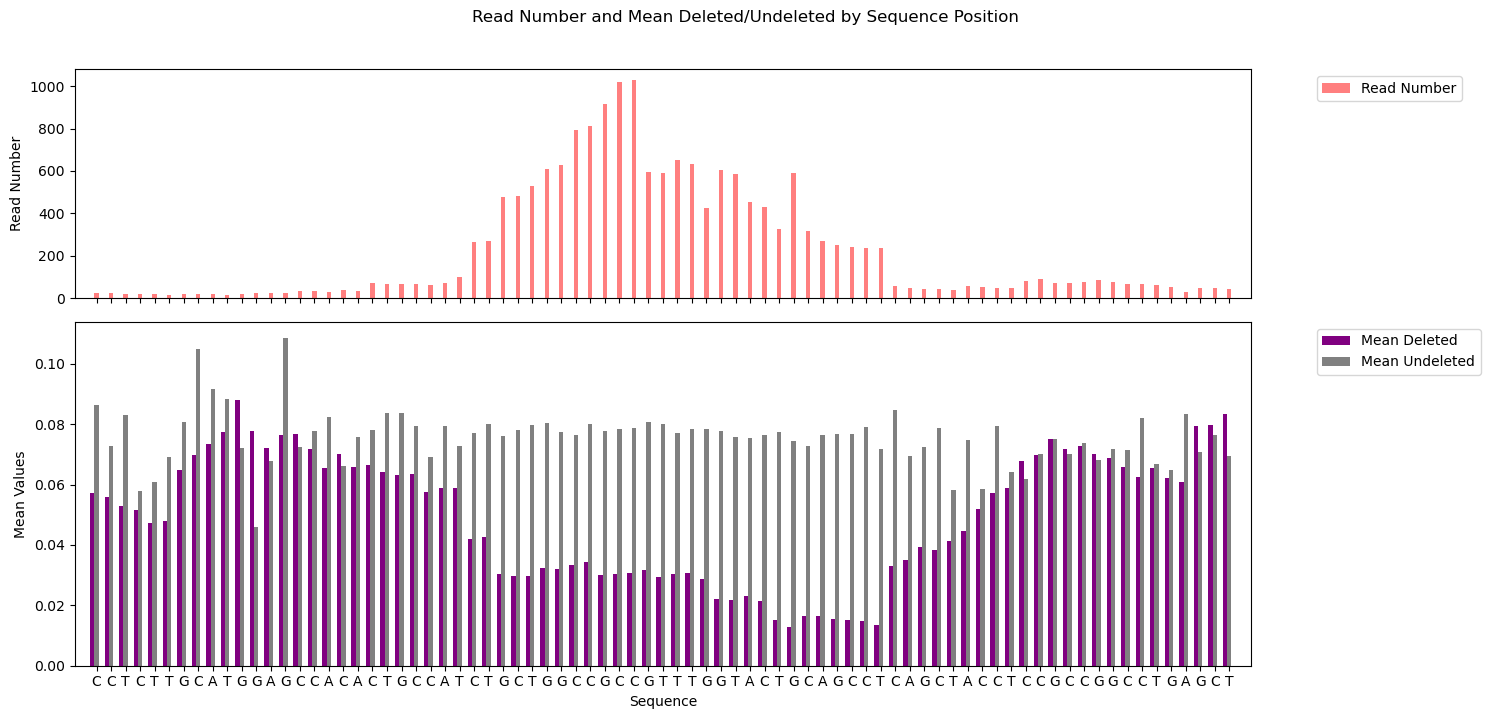

In [26]:
# Sequence of letters as the x-axis labels
sequence_labels = list("CCTCTTGCATGGAGCCACACTGCCATCTGCTGGCCGCCGTTTGGTACTGCAGCCTCAGCTACCTCCGCCGGCCTGAGCT")

# Ensure the length of sequence_labels matches the length of x-axis values
assert len(sequence_labels) == len(mut_df["motif_start"]), "Sequence length and motif_start length must match."

# Define bar width and x positions for each category
bar_width = 0.3
x = mut_df["motif_start"]

# Create two subplots stacked vertically
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 7), sharex=True, gridspec_kw={'height_ratios': [1, 1.5]})

# Top plot for read_number
ax1.bar(x, mut_df["read_number"], width=bar_width, color="red", alpha=0.5, label="Read Number")
ax1.set_ylabel("Read Number")
ax1.legend(loc="upper left", bbox_to_anchor=(1.05, 1))

# Bottom plot for mean_deleted and mean_undeleted
ax2.bar(x - bar_width, mut_df["mean_deleted"], width=bar_width, color="purple", label="Mean Deleted")
ax2.bar(x, mut_df["mean_undeleted"], width=bar_width, color="grey", label="Mean Undeleted")
ax2.set_ylabel("Mean Values")
ax2.set_xlabel("Sequence")
ax2.legend(loc="upper left", bbox_to_anchor=(1.05, 1))

# Set the x-axis ticks to sequence letters
ax2.set_xticks(x)
ax2.set_xticklabels(sequence_labels)

# Set x-axis limits with a small margin
margin = bar_width * 5
ax2.set_xlim([x.min() - margin, x.max() + margin])

# Title for the entire figure
fig.suptitle("Read Number and Mean Deleted/Undeleted by Sequence Position", y=1.02)

# Adjust layout and show plot
plt.tight_layout()
#plt.savefig(os.path.join(plot_dir, "HJR235_perbase_del_undel_readnum_seq_seperateplots_2590-2659_normalized.pdf"))
plt.show()
